In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### considertions:
- we took the **venue database** (imagine the virtual travellers who want to travel and be close to those venues( Google places), they pick them as their destinations
-  we took random sampels of the rows of this **venue database** n=1151 (to match the **events database** size) and saved it as **traveller database** (traveller.csv)
- we added date column of **events database** to the **traveller database**, as though the virtual travellers picked that dates for their travel
- we calculated (a) to what metro area  each traveller is close by (within max radius of 30 miles) and (b) calculated the distance from the travellers's location (former venue point) to the center of the city (center of this metro area identified by lat/long in US census data).  Assuming that the distance from downtown has effect on real estate and rental markets.
                                                           

# Questions
Understanding of events:

1. How long are the travellers trips? How popular or large are those venues the travellers chosen to be close by? 
2. What types of locations are they? 
3. How many cities of the tracellers data are included in the listings data?
4. what is the distribution of destinations over the metro area? How far those point fall from geographical center (e.g. for NYC,Boston etc defined by lat/long in US census data?

We looked at all NYC AirBnb listings from 2017 and noted whether there was a traveller going on on the date of the listing or if there was an another traveller 1,2,3,4,5,6 or 7 days after the date of the listing.

In [71]:
#tr_selection

,city,id,latitude,longitude,destination,num_types,state,types_rating,within_metro,miles
0,Chicago city,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,Chicago,7.823711
1,New York city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,New York,6.867661
2,New York city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,New York,10.221465
3,Washington city,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,Washington,6.530171
4,Washington city,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,Washington,1.828645
...,...,...,...,...,...,...,...,...,...,...
1146,New York city,54787bc5e9330d3aa5ebb974a02388ffdb448c88,40.783265,-73.835276,ShopRite of 20th Ave.,5,NY,1,New York,9.869501
1147,New York city,ea88acd070899cd93468ff69f256aba023d659a9,40.743395,-73.825799,Kung Fu Xiao Long Bao,4,NY,1,New York,8.073287
1148,Denver city,513c728d1eedd68c78955cf62f4aa76493b25078,39.728212,-104.998416,Mai Wyn Fine Art,3,CO,2,Denver,6.636798
1149,Chicago city,848411362ef4036d9a244222d453209b9ba2381e,41.793926,-87.684508,55th Street & Western Avenue,4,IL,0,Chicago,3.010649


# EDA

In [35]:


listings = pd.read_csv('data/new_listings.csv', encoding = "ISO-8859-1")

In [7]:
tr = pd.read_csv('data/travelers.csv', encoding = "ISO-8859-1")
calendar = pd.read_csv('data/calendar.csv', encoding = "ISO-8859-1")
tr_selection = pd.read_csv('data/travellers_selection.csv', encoding = "ISO-8859-1")




### Travelers

In [12]:
tr.dtypes

city             object
id               object
latitude        float64
longitude       float64
destination      object
num_types         int64
state            object
types_rating      int64
date             object
dtype: object

In [10]:
tr.head()

,city,id,latitude,longitude,destination,num_types,state,types_rating,date
0,chicago,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01
1,new york city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01
2,new york city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01
3,washington dc,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01
4,washington dc,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01


In [8]:
tr.shape[0]

1151

In [9]:
tr.groupby(['city']).size().sort_values(ascending=False).head(10)

city
new york city    566
chicago          280
denver           158
washington dc     97
boston            50
dtype: int64

Most of the travellers are in New York (included in the AirBnb listings) followed by several cities that are not included in the listings. 

In [13]:
tr['date'] = pd.to_datetime(tr['date'], dayfirst=True)
tr['length'] = tr.groupby(['destination'])['destination'].transform('size') #Add the length of each trip
tr['start_date'] = tr.groupby(['destination'])['date'].transform('min')
tr['end_date'] = tr.groupby(['destination'])['date'].transform('max')
tr

,city,id,latitude,longitude,destination,num_types,state,types_rating,date,length,start_date,end_date
0,chicago,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01,1,2017-02-01,2017-02-01
1,new york city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01,1,2017-04-01,2017-04-01
2,new york city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01,1,2017-05-01,2017-05-01
3,washington dc,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01,1,2017-05-01,2017-05-01
4,washington dc,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01,1,2017-05-01,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1146,new york city,54787bc5e9330d3aa5ebb974a02388ffdb448c88,40.783265,-73.835276,ShopRite of 20th Ave.,5,NY,1,2017-12-13,1,2017-12-13,2017-12-13
1147,new york city,ea88acd070899cd93468ff69f256aba023d659a9,40.743395,-73.825799,Kung Fu Xiao Long Bao,4,NY,1,2017-12-17,1,2017-12-17,2017-12-17
1148,denver,513c728d1eedd68c78955cf62f4aa76493b25078,39.728212,-104.998416,Mai Wyn Fine Art,3,CO,2,2017-12-29,1,2017-12-29,2017-12-29
1149,chicago,848411362ef4036d9a244222d453209b9ba2381e,41.793926,-87.684508,55th Street & Western Avenue,4,IL,0,2017-12-30,1,2017-12-30,2017-12-30


In [14]:
tr_selection.head(5)

,city,id,latitude,longitude,destination,num_types,state,types_rating,date,latitude_radians,longitude_radians,within_metro,miles
0,Chicago city,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01,0.732152,-1.529865,Chicago,7.823711
1,New York city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01,0.711331,-1.291308,New York,6.867661
2,New York city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01,0.712298,-1.290574,New York,10.221465
3,Washington city,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01,0.680487,-1.345141,Washington,6.530171
4,Washington city,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01,0.678822,-1.343647,Washington,1.828645


In [15]:
tr_selection.groupby(['within_metro'])['within_metro'].count().sort_values(ascending=False).head(10)

within_metro
New York      566
Chicago       280
Denver        158
Washington     97
Boston         50
Name: within_metro, dtype: int64

Filter for events that are within 20 miles of a major metropolitan area that is listed in the AirBnb data

In [36]:
listings.columns

Index(['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds',
       'host_id', 'id', 'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'weekly_price',
       'instant_bookable_f', 'instant_bookable_t', 'metropolitan_NYC',
       'metropolitan_boston', 'metropolitan_chicago', 'metropolitan_dc',
       'metropolitan_denver', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'price',
       'metropolitan'],
      dtype='object')

In [37]:
listings.metropolitan

0        NYC
1        NYC
2        NYC
3        NYC
4        NYC
        ... 
59815     dc
59816     dc
59817     dc
59818     dc
59819     dc
Name: metropolitan, Length: 59820, dtype: object

In [38]:
listings.groupby(['metropolitan']).size()

metropolitan
NYC        40740
boston      3582
chicago     5207
dc          7787
denver      2504
dtype: int64

We do have enough information about the destinations to determine what type they are (churches, restaurants, etc.) and how popular they are (ratings that came from venue dataset). We can get how long each event is. Most of the destinations are NYC as are most of the listings in our dataset. It would be ideal to have more granular data about the location of the events. For now, I will focus on NYC in particular.

First, I'll look at the average price of an AirBnb in NYC throughout the year 2017. Then I'll look at the average price of the AirBnb in different neighborhoods.

In [39]:
listings['ref_price'] = listings['price']
listings_pricedropped = listings.drop(columns=['price'])
listings_pricedropped.head(5)

,accommodates,availability_30,bathrooms,bedrooms,beds,host_id,id,review_scores_checkin,review_scores_cleanliness,review_scores_communication,...,metropolitan_NYC,metropolitan_boston,metropolitan_chicago,metropolitan_dc,metropolitan_denver,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,metropolitan,ref_price
0,2.0,24,1.0,1.0,1.0,119445,7949480,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,NYC,99.0
1,4.0,30,1.0,1.0,1.0,9117975,16042478,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,NYC,200.0
2,4.0,30,3.0,3.0,3.0,9815788,1886820,10.0,10.0,10.0,...,1,0,0,0,0,1,0,0,NYC,300.0
3,3.0,8,1.0,1.0,1.0,13886510,6627449,10.0,10.0,10.0,...,1,0,0,0,0,1,0,0,NYC,125.0
4,4.0,17,1.0,1.0,1.0,28811542,5557381,10.0,10.0,10.0,...,1,0,0,0,0,0,1,0,NYC,69.0


In [40]:
listings.set_index('id')['price'].isna().sum()

0

In [41]:
print(calendar.set_index('date')['price'].isna().sum(level=0).sort_values(ascending=False))
calendar.set_index('listing_id')['price'].isna().sum(level=0).sort_values(ascending=False)

date
2017-05-19    45155.0
2017-05-20    44986.0
2017-05-13    44397.0
2017-05-12    44371.0
2017-05-11    43974.0
               ...   
2016-08-15     1060.0
2016-08-14     1038.0
2018-05-10      788.0
2016-05-18      760.0
2016-05-17      352.0
Name: price, Length: 724, dtype: float64


listing_id
12898806    570.0
6881827     365.0
1308155     365.0
4978798     365.0
13623182    365.0
            ...  
8402732       0.0
11274799      0.0
3943630       0.0
5786059       0.0
17718893      0.0
Name: price, Length: 59838, dtype: float64

In [42]:
merged = calendar.merge(listings_pricedropped, how='inner', left_on='listing_id', right_on='id')
merged.head(5)

,listing_id,date,available,price,metro_area,accommodates,availability_30,bathrooms,bedrooms,beds,...,metropolitan_NYC,metropolitan_boston,metropolitan_chicago,metropolitan_dc,metropolitan_denver,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,metropolitan,ref_price
0,2515,2018-03-05,t,69.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
1,2515,2018-03-04,t,69.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
2,2515,2018-03-03,t,69.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
3,2515,2018-03-02,t,69.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
4,2515,2018-03-01,t,69.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0


In [43]:
merged['date'] = pd.to_datetime(merged['date'])
merged_NY2017only = merged[merged['metropolitan'] == 'NYC'] 
merged_NY2017only = merged_NY2017only[merged_NY2017only['date'].dt.year == 2017]
merged_NY2017only

,listing_id,date,available,price,metro_area,accommodates,availability_30,bathrooms,bedrooms,beds,...,metropolitan_NYC,metropolitan_boston,metropolitan_chicago,metropolitan_dc,metropolitan_denver,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,metropolitan,ref_price
64,2515,2017-12-31,t,169.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
65,2515,2017-12-30,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
66,2515,2017-12-29,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
67,2515,2017-12-28,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
68,2515,2017-12-27,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,1,0,0,0,0,0,1,0,NYC,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14870095,18519989,2017-05-07,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,1,0,0,0,0,1,0,0,NYC,151.0
14870096,18519989,2017-05-06,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,1,0,0,0,0,1,0,0,NYC,151.0
14870097,18519989,2017-05-05,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,1,0,0,0,0,1,0,0,NYC,151.0
14870098,18519989,2017-05-04,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,1,0,0,0,0,1,0,0,NYC,151.0


In [44]:
print(merged_NY2017only['price'].isna().sum())
print(merged_NY2017only['ref_price'].isna().sum())
print(merged_NY2017only.set_index('date')['price'].isna().sum(level=0).sort_values(ascending=False))
merged_NY2017only.set_index('listing_id')['price'].isna().sum(level=0).sort_values(ascending=False)

6304428
0
date
2017-05-05    34670.0
2017-05-06    34052.0
2017-05-19    32236.0
2017-05-20    31977.0
2017-05-18    31872.0
               ...   
2017-07-29    22604.0
2017-07-30    22235.0
2017-07-31    22036.0
2017-05-03    21552.0
2017-05-02     1777.0
Name: price, Length: 244, dtype: float64


listing_id
4983691     244.0
265194      244.0
13504845    244.0
13503536    244.0
12585689    244.0
            ...  
775016        0.0
16948224      0.0
773497        0.0
18084651      0.0
1832223       0.0
Name: price, Length: 40740, dtype: float64

In [47]:
merged_NY2017only.columns

Index(['listing_id', 'date', 'available', 'price', 'metro_area',
       'accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds',
       'host_id', 'id', 'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'weekly_price',
       'instant_bookable_f', 'instant_bookable_t', 'metropolitan_NYC',
       'metropolitan_boston', 'metropolitan_chicago', 'metropolitan_dc',
       'metropolitan_denver', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'metropolitan',
       'ref_price'],
      dtype='object')

We need to take care of missing values from the merged dataset.

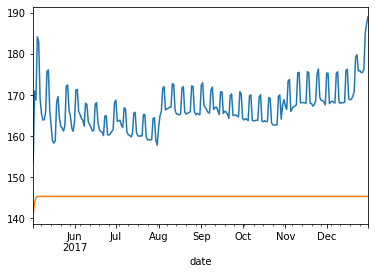

In [45]:
merged_NY2017only.groupby('date')['price'].mean().plot()
merged_NY2017only.groupby('date')['ref_price'].mean().plot()

There is an unexplained dip in the average AirBnb reference price in May. The average reference price is just the average price of the listings (they shouldn't be dependent on the date since there is only 1 price given per listing). The dip might be because there is no data for some of the listings at the specific May date.

It seems like the neighborhood of NY affects the average AirBnb price (as expected). The prices do not fluctuate a lot over the year, though there are some small steps at certain times (based on the 4 neighborhoods I visualized - it may change if I look at others). In order to try with a more granular events database, I tried to look at events using the NYC Permitted Events dataset (https://data.cityofnewyork.us/City-Government/NYC-Permitted-Event-Information-Historical/bkfu-528j). However, there are too many events in this database, including ones that are not large events which many people would book AirBnbs for and it was not possible to filter those events out.

Filter for events that are within 15 mi of New York City (doesn't change the number much for NYC). Add features to full dataset: for each listing (each row), is an event happening the day of, in 1 day, 2 days, 3 days, 4 days, 5 days, 6 days, 7 days?

In [48]:
tr_selection.columns

Index(['city', 'id', 'latitude', 'longitude', 'destination', 'num_types',
       'state', 'types_rating', 'date', 'latitude_radians',
       'longitude_radians', 'within_metro', 'miles'],
      dtype='object')

In [49]:
tr_selection.head()

,city,id,latitude,longitude,destination,num_types,state,types_rating,date,latitude_radians,longitude_radians,within_metro,miles
0,Chicago city,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,Wrigley Rooftops 1010 West Waveland,5,IL,0,2017-02-01,0.732152,-1.529865,Chicago,7.823711
1,New York city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,Walgreens Pharmacy,5,NY,0,2017-04-01,0.711331,-1.291308,New York,6.867661
2,New York city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,Harlem Your Way Tours Unlimited,3,NY,1,2017-05-01,0.712298,-1.290574,New York,10.221465
3,Washington city,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,East-West Hwy & Brookeville Rd,4,DC,1,2017-05-01,0.680487,-1.345141,Washington,6.530171
4,Washington city,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,C St NE & 14th St NE,4,DC,1,2017-05-01,0.678822,-1.343647,Washington,1.828645


In [70]:
tr_selection.drop(['date','latitude_radians','longitude_radians'], axis = 1, inplace = True)
#tr_selection


In [76]:
tr.drop(['num_types','types_rating','state'], axis = 1, inplace=True)

In [77]:
tr_selection_merged = tr_selection.iloc[:,4:].merge(tr, how='inner', on='destination')



In [81]:
tr_selection_merged
#tr_selection_merged.shape

,destination,num_types,state,types_rating,within_metro,miles,city,id,latitude,longitude,date,length,start_date,end_date
0,Wrigley Rooftops 1010 West Waveland,5,IL,0,Chicago,7.823711,chicago,2622c79ed752724e7f4f691c185be6aeee145344,41.949237,-87.654804,2017-02-01,1,2017-02-01,2017-02-01
1,Walgreens Pharmacy,5,NY,0,New York,6.867661,new york city,1d4e080afa70d25050471feb96c8154455b91f6d,40.756259,-73.986508,2017-04-01,1,2017-04-01,2017-04-01
2,Harlem Your Way Tours Unlimited,3,NY,1,New York,10.221465,new york city,cba18363393cad37acdd3c5246e4c4738be153e0,40.811669,-73.944428,2017-05-01,1,2017-05-01,2017-05-01
3,East-West Hwy & Brookeville Rd,4,DC,1,Washington,6.530171,washington dc,3adf58a2e8c0bc1996c669df31cef1b145696647,38.989005,-77.070891,2017-05-01,1,2017-05-01,2017-05-01
4,C St NE & 14th St NE,4,DC,1,Washington,1.828645,washington dc,b0a227a0bf0d80695cb7d4355bc85d3b3e42bb86,38.893633,-76.985282,2017-05-01,1,2017-05-01,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,ShopRite of 20th Ave.,5,NY,1,New York,9.869501,new york city,54787bc5e9330d3aa5ebb974a02388ffdb448c88,40.783265,-73.835276,2017-12-13,1,2017-12-13,2017-12-13
1225,Kung Fu Xiao Long Bao,4,NY,1,New York,8.073287,new york city,ea88acd070899cd93468ff69f256aba023d659a9,40.743395,-73.825799,2017-12-17,1,2017-12-17,2017-12-17
1226,Mai Wyn Fine Art,3,CO,2,Denver,6.636798,denver,513c728d1eedd68c78955cf62f4aa76493b25078,39.728212,-104.998416,2017-12-29,1,2017-12-29,2017-12-29
1227,55th Street & Western Avenue,4,IL,0,Chicago,3.010649,chicago,848411362ef4036d9a244222d453209b9ba2381e,41.793926,-87.684508,2017-12-30,1,2017-12-30,2017-12-30


In [82]:

tr_selection_NY = tr_selection_merged[tr_selection_merged['within_metro'] == 'New York']
merged_NY2017only['dayof'] = merged_NY2017only['date'].isin(tr_selection_NY['date'])    
merged_NY2017only['in_1day'] = (merged_NY2017only['date'] + pd.Timedelta(days=1)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_2days'] = (merged_NY2017only['date'] + pd.Timedelta(days=2)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_3days'] = (merged_NY2017only['date'] + pd.Timedelta(days=3)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_4days'] = (merged_NY2017only['date'] + pd.Timedelta(days=4)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_5days'] = (merged_NY2017only['date'] + pd.Timedelta(days=5)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_6days'] = (merged_NY2017only['date'] + pd.Timedelta(days=6)).isin(tr_selection_NY['date'])  
merged_NY2017only['in_7days'] = (merged_NY2017only['date'] + pd.Timedelta(days=7)).isin(tr_selection_NY['date'])  
merged_NY2017only

,listing_id,date,available,price,metro_area,accommodates,availability_30,bathrooms,bedrooms,beds,...,metropolitan,ref_price,dayof,in_1day,in_2days,in_3days,in_4days,in_5days,in_6days,in_7days
64,2515,2017-12-31,t,169.0,NYC,2.0,5,1.0,1.0,2.0,...,NYC,59.0,True,False,False,False,False,False,False,False
65,2515,2017-12-30,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,NYC,59.0,False,True,False,False,False,False,False,False
66,2515,2017-12-29,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,NYC,59.0,False,False,True,False,False,False,False,False
67,2515,2017-12-28,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,NYC,59.0,False,False,False,True,False,False,False,False
68,2515,2017-12-27,t,129.0,NYC,2.0,5,1.0,1.0,2.0,...,NYC,59.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14870095,18519989,2017-05-07,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,NYC,151.0,True,True,True,True,False,True,True,True
14870096,18519989,2017-05-06,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,NYC,151.0,True,True,True,True,True,False,True,True
14870097,18519989,2017-05-05,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,NYC,151.0,True,True,True,True,True,True,False,True
14870098,18519989,2017-05-04,f,NaN,NYC,4.0,0,1.0,2.0,2.0,...,NYC,151.0,True,True,True,True,True,True,True,False


In [83]:
merged_NY2017only.columns

Index(['listing_id', 'date', 'available', 'price', 'metro_area',
       'accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds',
       'host_id', 'id', 'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'weekly_price',
       'instant_bookable_f', 'instant_bookable_t', 'metropolitan_NYC',
       'metropolitan_boston', 'metropolitan_chicago', 'metropolitan_dc',
       'metropolitan_denver', 'room_type_Entire home/apt',
       'room_type_Private room', 'room_type_Shared room', 'metropolitan',
       'ref_price', 'dayof', 'in_1day', 'in_2days', 'in_3days', 'in_4days',
       'in_5days', 'in_6days', 'in_7days'],
      dtype='object')

In [ ]:
'metropolitan','listing_id','host_id'

In [84]:
merged_NY2017only.isnull().sum()

listing_id                           0
date                                 0
available                            0
price                          6304428
metro_area                           0
accommodates                         0
availability_30                      0
bathrooms                            0
bedrooms                             0
beds                                 0
host_id                              0
id                                   0
review_scores_checkin                0
review_scores_cleanliness            0
review_scores_communication          0
review_scores_location               0
review_scores_rating                 0
review_scores_value                  0
weekly_price                         0
instant_bookable_f                   0
instant_bookable_t                   0
metropolitan_NYC                     0
metropolitan_boston                  0
metropolitan_chicago                 0
metropolitan_dc                      0
metropolitan_denver      

In [87]:
merged_NY2017only.groupby(['listing_id'])['price'].median()

listing_id
2515         99.0
2595        225.0
3647        150.0
3831         96.0
4611         46.0
            ...  
18516880    115.0
18517599     49.0
18519090     62.0
18519472     37.0
18519989    156.0
Name: price, Length: 40740, dtype: float64

In [89]:
### still there are some NaNs
merged_NY2017only.groupby('listing_id')['price'].median().isnull().sum()

12850

In [91]:
merged_NY2017only['price']=merged_NY2017only.groupby('listing_id')['price'].apply(lambda x:x.fillna(x.mean()))
merged_NY2017only.isnull().sum().sum()

3116132

In [92]:
merged_NY2017only.isnull().sum()

listing_id                           0
date                                 0
available                            0
price                          3116132
metro_area                           0
accommodates                         0
availability_30                      0
bathrooms                            0
bedrooms                             0
beds                                 0
host_id                              0
id                                   0
review_scores_checkin                0
review_scores_cleanliness            0
review_scores_communication          0
review_scores_location               0
review_scores_rating                 0
review_scores_value                  0
weekly_price                         0
instant_bookable_f                   0
instant_bookable_t                   0
metropolitan_NYC                     0
metropolitan_boston                  0
metropolitan_chicago                 0
metropolitan_dc                      0
metropolitan_denver      

#### the average price cannot be calculated for listing if all the listing price in NaN

In [106]:
merged_NY2017only[merged_NY2017only['price'].isnull()].groupby('listing_id').size()

listing_id
7322        241
11174       243
13050       243
15345       243
16076       243
           ... 
18475999    243
18477211    242
18489157    243
18489489    243
18500972    241
Length: 12850, dtype: int64

In [120]:
merged_NY2017only[merged_NY2017only['listing_id']==7322]

,listing_id,date,available,price,metro_area,accommodates,availability_30,bathrooms,bedrooms,beds,...,metropolitan,ref_price,dayof,in_1day,in_2days,in_3days,in_4days,in_5days,in_6days,in_7days
7761,7322,2017-12-31,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,True,False,False,False,False,False,False,False
7762,7322,2017-12-30,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,False,True,False,False,False,False,False,False
7763,7322,2017-12-29,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,False,False,True,False,False,False,False,False
7764,7322,2017-12-28,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,False,False,False,True,False,False,False,False
7765,7322,2017-12-27,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8025,7322,2017-05-09,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,True,True,False,True,True,True,True,True
8026,7322,2017-05-08,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,True,True,True,False,True,True,True,True
8027,7322,2017-05-07,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,True,True,True,True,False,True,True,True
8028,7322,2017-05-06,f,NaN,NYC,3.0,0,1.0,1.0,1.0,...,NYC,120.0,True,True,True,True,True,False,True,True


In [121]:
merged_NY2017only[merged_NY2017only['listing_id']==7322].price.isnull().sum()

241

### That means that every single value of price was NaN= we can drop those listing as they were not active during the 2017

-listing IDs:
 - 7322,11174,13050,15345,16076

In [ ]:
df.dropna()

In [129]:
merged_NY2017only.dropna(how='any', axis = 0,subset = ['price'], inplace=True)

In [130]:
merged_NY2017only.isnull().sum()

listing_id                     0
date                           0
available                      0
price                          0
metro_area                     0
accommodates                   0
availability_30                0
bathrooms                      0
bedrooms                       0
beds                           0
host_id                        0
id                             0
review_scores_checkin          0
review_scores_cleanliness      0
review_scores_communication    0
review_scores_location         0
review_scores_rating           0
review_scores_value            0
weekly_price                   0
instant_bookable_f             0
instant_bookable_t             0
metropolitan_NYC               0
metropolitan_boston            0
metropolitan_chicago           0
metropolitan_dc                0
metropolitan_denver            0
room_type_Entire home/apt      0
room_type_Private room         0
room_type_Shared room          0
metropolitan                   0
ref_price 

In [132]:
merged_NY2017only.shape

(6764057, 39)